In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np




In [2]:
# Load the Titanic dataset
titanic_df = pd.read_csv('train.csv')

# Drop columns that are not useful for prediction
titanic_df = titanic_df.drop(['Name',  'Cabin'], axis=1)


In [3]:
# Handle missing values
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)



In [4]:
# Convert categorical variables to numerical
encoder = LabelEncoder()
titanic_df['Sex'] = encoder.fit_transform(titanic_df['Sex'])
titanic_df['Embarked'] = encoder.fit_transform(titanic_df['Embarked'])
titanic_df['Ticket'] = encoder.fit_transform(titanic_df['Ticket'])



In [5]:
# Define features and target variable
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']



In [6]:
numeric_cols = X.select_dtypes(np.number).columns.to_list()

scaler = MinMaxScaler()

scaler.fit(X[numeric_cols])

X[numeric_cols] = scaler.transform(X[numeric_cols])

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



<Figure size 1200x600 with 0 Axes>

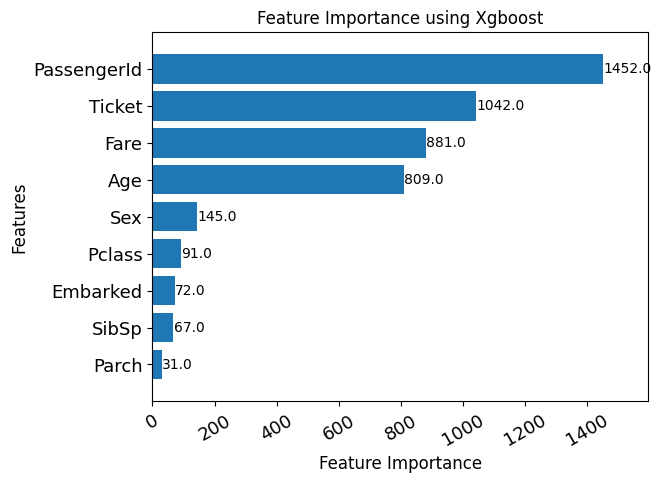

In [8]:
# Define XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_estimators=500)

# Train XGBoost classifier
xgb_classifier.fit(X_train, y_train)

# Plot relative importance of features
plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_classifier, height=0.8, grid=False)
plt.xticks(fontsize=13, rotation=30)
plt.yticks(fontsize=13)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance using Xgboost', fontsize=12)
plt.savefig('xgboost.png')
plt.show()

In [9]:
X.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

In [10]:
feats = ['PassengerId', 'Fare', 'Age', 'SibSp',  'Pclass', 'Sex', 'Ticket', 'Parch', 'Embarked']

hey = []
threshold = 0.75
for i in range(len(feats)):
    hey.append(feats[i])
    ttt = X_train[hey]
    model = LogisticRegression(random_state=42).fit(ttt, y_train)
    predictions = model.predict(X_test[hey])
    accuracy = accuracy_score(y_test, predictions)
    print(f"Features: {hey}\t Accuracy: {accuracy}")

Features: ['PassengerId']	 Accuracy: 0.5865921787709497
Features: ['PassengerId', 'Fare']	 Accuracy: 0.6033519553072626
Features: ['PassengerId', 'Fare', 'Age']	 Accuracy: 0.6145251396648045
Features: ['PassengerId', 'Fare', 'Age', 'SibSp']	 Accuracy: 0.6201117318435754
Features: ['PassengerId', 'Fare', 'Age', 'SibSp', 'Pclass']	 Accuracy: 0.7541899441340782
Features: ['PassengerId', 'Fare', 'Age', 'SibSp', 'Pclass', 'Sex']	 Accuracy: 0.7877094972067039
Features: ['PassengerId', 'Fare', 'Age', 'SibSp', 'Pclass', 'Sex', 'Ticket']	 Accuracy: 0.8044692737430168
Features: ['PassengerId', 'Fare', 'Age', 'SibSp', 'Pclass', 'Sex', 'Ticket', 'Parch']	 Accuracy: 0.8044692737430168
Features: ['PassengerId', 'Fare', 'Age', 'SibSp', 'Pclass', 'Sex', 'Ticket', 'Parch', 'Embarked']	 Accuracy: 0.7932960893854749


In [11]:
cols_to_use = [ 'SibSp', 'Pclass', 'Age', 'PassengerId', 'Sex']

mddd = LogisticRegression().fit(X_train[cols_to_use], y_train)

pred33 = mddd.predict(X_test[cols_to_use])

acc = accuracy_score(y_test, pred33)
print(acc)

0.7932960893854749


In [12]:
mddd.predict_proba(X_test[cols_to_use])

array([[0.89428113, 0.10571887],
       [0.76164409, 0.23835591],
       [0.85217498, 0.14782502],
       [0.12376336, 0.87623664],
       [0.38561174, 0.61438826],
       [0.08635977, 0.91364023],
       [0.38891766, 0.61108234],
       [0.90000507, 0.09999493],
       [0.34028959, 0.65971041],
       [0.07944072, 0.92055928],
       [0.65110555, 0.34889445],
       [0.90679417, 0.09320583],
       [0.50971035, 0.49028965],
       [0.89456489, 0.10543511],
       [0.78434484, 0.21565516],
       [0.06093798, 0.93906202],
       [0.63909194, 0.36090806],
       [0.36290394, 0.63709606],
       [0.71941816, 0.28058184],
       [0.65670524, 0.34329476],
       [0.88111243, 0.11888757],
       [0.57047434, 0.42952566],
       [0.39788922, 0.60211078],
       [0.85832033, 0.14167967],
       [0.88142779, 0.11857221],
       [0.89167782, 0.10832218],
       [0.63049445, 0.36950555],
       [0.74804033, 0.25195967],
       [0.90256174, 0.09743826],
       [0.39597444, 0.60402556],
       [0.

In [13]:
y_test

709    1
439    0
840    0
720    1
39     1
      ..
433    0
773    0
25     1
84     1
10     1
Name: Survived, Length: 179, dtype: int64

In [14]:
pred33

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1], dtype=int64)

In [15]:
pd.DataFrame({'target': y_test, 'preds': pred33})

,target,preds
709,1,0
439,0,0
840,0,0
720,1,1
39,1,1
...,...,...
433,0,0
773,0,0
25,1,0
84,1,1
